### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [45]:
import random

import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
# %conda install wget

In [46]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2024-12-01 20:53:57--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [             <=>    ] 201.24M  17.1MB/s    in 12s     

2024-12-01 20:54:10 (16.3 MB/s) - ‘data.txt.zip’ saved [211011981]



In [47]:
df = pd.read_csv("data.txt.zip", header=None)
df.shape

(515345, 91)

In [ ]:
count_values = df[0].value_counts()
print(count_values)

0
2007    39404
2006    37534
2005    34952
2008    34760
2009    31038
        ...  
1925        7
1922        6
1933        6
1924        5
2011        1
Name: count, Length: 89, dtype: int64


Слишком большая размерность для такого количества данных, нужно будет понизить.

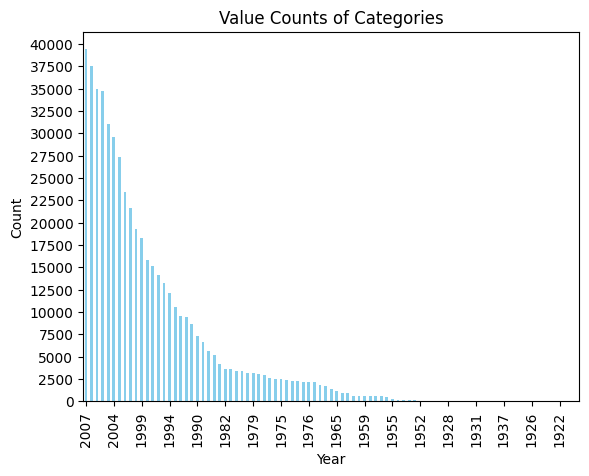

In [ ]:
count_values = df[0].value_counts()

count_values.plot(kind='bar', color='skyblue')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Value Counts of Categories')
plt.locator_params(axis='both', nbins=20)
plt.show()

In [48]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

mask = (y >= 1950) & (y <= 2010)
X = X[mask]
y = y[mask]

#y_mean = y.mean()
#y_std = y.std()
#y_normalized = (y - y_mean) / y_std

#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()
#y = le.fit_transform(y)



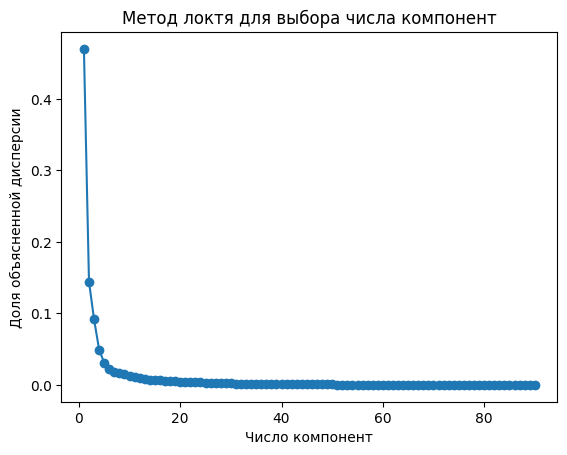

In [ ]:
pca = PCA()

pca.fit(X)

explained_variance_ratio = pca.explained_variance_ratio_
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel("Число компонент")
plt.ylabel("Доля объясненной дисперсии")
plt.title("Метод локтя для выбора числа компонент")
plt.show()

Сетка очень крупная, но, кажется, перегиб где-то в районе 5-7. С нашим кол-вом данных (500 тыс. объектов) мы больше 7 фичей себе позволить (кажется) и не можем. PCA вставила после StandartScaler'а.

In [ ]:
X.shape

(515345, 10)

In [49]:
train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [ ]:
df[0].nunique()

89

In [ ]:
len(np.unique(y_train))

89

In [ ]:
from sklearn.manifold import TSNE
#как нарисовать точки в пространстве при огромной размерности, я, конечно же, нагуглила, надеюсь, так можно
sample_size = 10000
random_indices = np.random.choice(len(X), sample_size, replace=False)
X_sample = X[random_indices]
y_sample = y[random_indices]

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X_sample)



/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


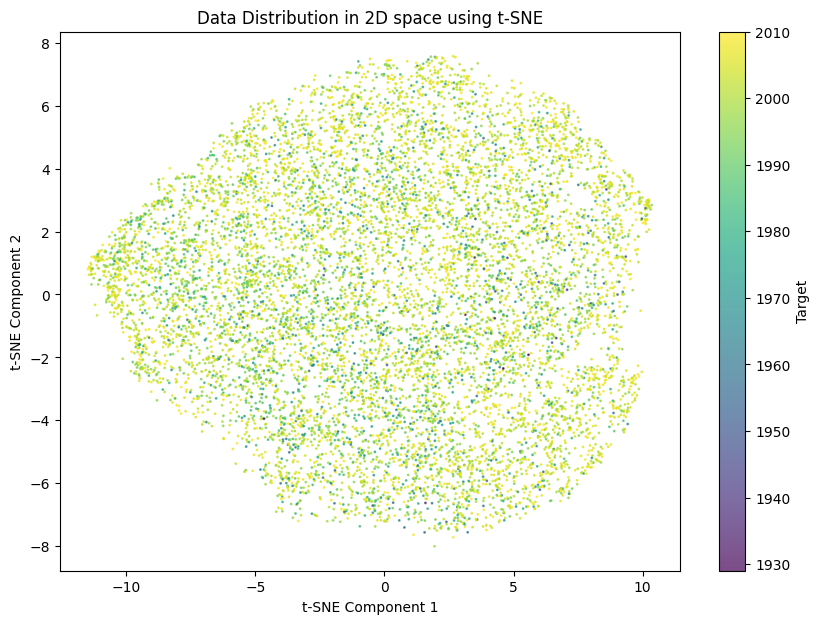

In [ ]:


plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sample, cmap='viridis', s=1, alpha=0.7)
plt.colorbar(label='Target')
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Data Distribution in 2D space using t-SNE")
plt.show()

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [50]:
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split


In [51]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#pca = PCA(0.95)
#X_train = pca.fit_transform(X_train)
#X_test = pca.fit_transform(X_test)


#y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
#y_test = scaler.fit_transform(y_test.reshape(-1, 1)).flatten()

In [ ]:
for a in np.arange(10, 10.1, 2.5):
    regressor = Ridge(alpha=a)
    regressor.fit(X_train, y_train)

    ypred = regressor.predict(X_test)
    rmse = root_mean_squared_error(y_test, ypred)

    print('alpha={}'.format(a))
    print("RMSE:", rmse)


alpha=10.0
RMSE: 9.268683727395489


In [52]:
from sklearn.linear_model import RidgeCV

n_alphas = 200
ridge_alphas = np.logspace(-2, 6, n_alphas)

ridge_cv = RidgeCV(alphas=ridge_alphas,
                   scoring='neg_root_mean_squared_error',
                   cv=3)
ridge_cv.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000000e-02, 1.09698580e-02, 1.20337784e-02, 1.32008840e-02,
       1.44811823e-02, 1.58856513e-02, 1.74263339e-02, 1.91164408e-02,
       2.09704640e-02, 2.30043012e-02, 2.52353917e-02, 2.76828663e-02,
       3.03677112e-02, 3.33129479e-02, 3.65438307e-02, 4.00880633e-02,
       4.39760361e-02, 4.82410870e-02, 5.29197874e-02, 5.80522552e-02,
       6.36824994e-02, 6.98587975e-0...
       1.18953407e+05, 1.30490198e+05, 1.43145894e+05, 1.57029012e+05,
       1.72258597e+05, 1.88965234e+05, 2.07292178e+05, 2.27396575e+05,
       2.49450814e+05, 2.73644000e+05, 3.00183581e+05, 3.29297126e+05,
       3.61234270e+05, 3.96268864e+05, 4.34701316e+05, 4.76861170e+05,
       5.23109931e+05, 5.73844165e+05, 6.29498899e+05, 6.90551352e+05,
       7.57525026e+05, 8.30994195e+05, 9.11588830e+05, 1.00000000e+06]),
        cv=3, scoring='neg_root_mean_squared_error')

In [55]:
a = ridge_cv.alpha_

In [56]:
regressor2 = Ridge(alpha=a)
regressor2.fit(X_train, y_train)

ypred2 = regressor2.predict(X_test)

print('alpha={}'.format(a))
print("RMSE:", root_mean_squared_error(y_test, ypred2))

alpha=348.9101213406774
RMSE: 9.268671992323464


Ожидание подбора параметров того не стоило...

In [ ]:

sample_size = 10000
random_indices = np.random.choice(len(X_test), sample_size, replace=False)
X_sample = X_test[random_indices]
y_pred_sample = ypred[random_indices]

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X_sample)



/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


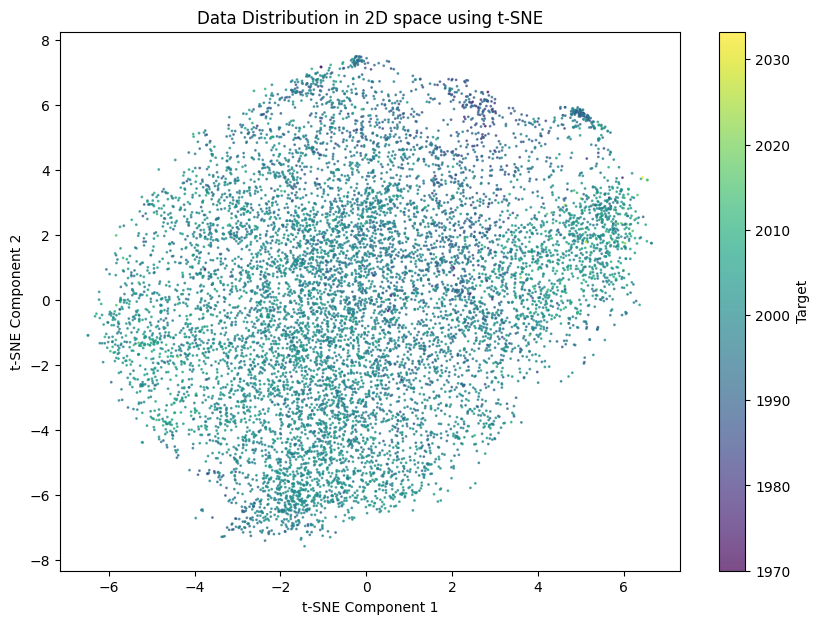

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_pred_sample, cmap='viridis', s=1, alpha=0.7)
plt.colorbar(label='Target')
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Data Distribution in 2D space using t-SNE")
plt.show()

Есть ощущение, что предсказанные годы выпуска песен оказались в более позднем промежутке, чем они были в выборке. Судя по первой картинке (в начале), песен первой половины 20 в. в датасете было мало, и эти годы выпуска модель почти не предсказывает, зато появились 2020-е.

In [ ]:
sample_size = 10000
random_indices = np.random.choice(len(X_test), sample_size, replace=False)
X_sample = X_test[random_indices]
y_test_sample = y_test[random_indices]

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X_sample)



/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


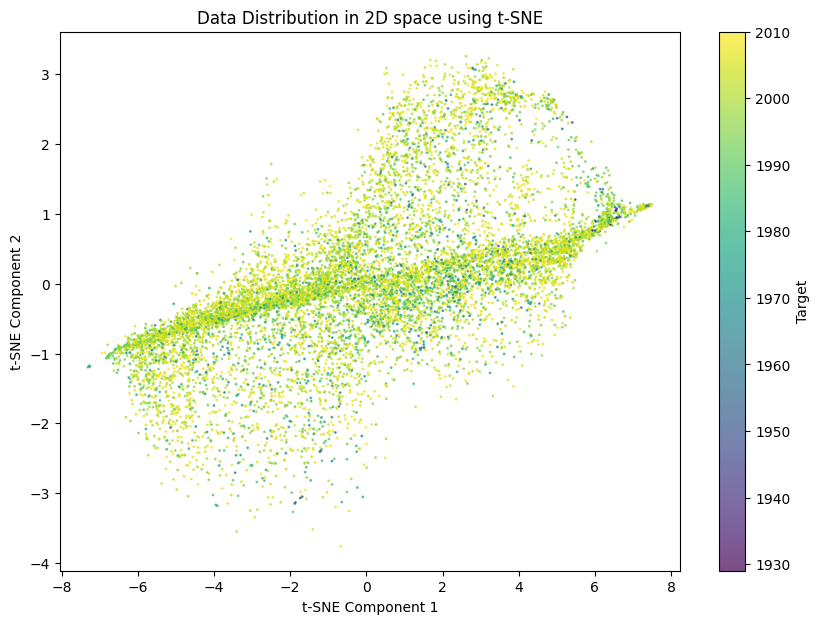

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test_sample, cmap='viridis', s=1, alpha=0.7)
plt.colorbar(label='Target')
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Data Distribution in 2D space using t-SNE")
plt.show()

Выборки для графиков были рандомные, но, похоже, в тесте песни были все-таки постарее, чем их регрессия определила.

## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils


In [15]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [16]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [25]:
INPUT_SIZE = 90
HIDDEN_SIZE1 = 128
HIDDEN_SIZE2 = 64
HIDDEN_SIZE3 = 32
OUTPUT_SIZE = 1
BATCH_SIZE = 256
EPOCHS = 50
LEARNING_RATE = 0.05

In [18]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [31]:
set_random_seed(53)
def create_data_loader(X_train, y_train, X_test, y_test):
    train_tensor = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train))
    train_loader = data_utils.DataLoader(dataset=train_tensor,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)

    test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test))
    test_loader = data_utils.DataLoader(dataset=test_tensor,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)
    return train_loader, test_loader

train_loader, test_loader = create_data_loader(X_train, y_train, X_test, y_test)

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        """тут мы просто объявляем, какие нам нужны слои,
        и сохраняем их в динамических атрибутах"""
        super().__init__()
        self.fc1 = nn.Linear(in_features=INPUT_SIZE, out_features=HIDDEN_SIZE1)
        #self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(in_features=HIDDEN_SIZE1, out_features=HIDDEN_SIZE2)
        #self.fc3 = nn.Linear(in_features=HIDDEN_SIZE2, out_features=HIDDEN_SIZE3)
        self.out = nn.Linear(in_features=HIDDEN_SIZE2, out_features=OUTPUT_SIZE)



    def forward(self, x):
        """Этот метод будет вызываться невидимо для нас,
        когда мы передаем в модель данные (подумаем про __call__...)"""
        x = torch.relu(self.fc1(x))
        #x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        #x = torch.relu(self.fc3(x))
        x = self.out(x)
        return x

In [32]:
def train(model, optimizer, criterion, train_loader, scheduler=None):
    train_loss_values = []
    train_rmse_values = []

    model.train()
    for epoch in range(EPOCHS):
        running_loss = 0.0
        running_rmse = 0.0
        n_samples = 0

        for features, label in train_loader:
            features, label = features.to(DEVICE).float(), label.to(DEVICE).float()
            optimizer.zero_grad()

            # Прямой проход и расчет потерь
            output = model(features).squeeze(-1)
            loss = criterion(output, label)

            # Обратное распространение ошибки и шаг оптимизации
            loss.backward()
            optimizer.step()

            # Подсчет rmse
            rmse = torch.sqrt(loss).item()

            running_loss += loss.item() * features.size(0)
            running_rmse += rmse * features.size(0)
            n_samples += features.size(0)

        epoch_loss = running_loss / n_samples
        epoch_rmse = running_rmse / n_samples

        train_loss_values.append(epoch_loss)
        train_rmse_values.append(epoch_rmse)

        if scheduler is not None:
            scheduler.step()

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"EPOCH {epoch + 1}, train_loss: {epoch_loss:.4f}, train_rmse: {epoch_rmse:.4f}")

    return train_loss_values, train_rmse_values


def test(model, criterion, test_loader):
    model.eval()
    valid_loss = 0.0
    predictions = []
    all_labels = []
    n_samples = 0

    with torch.no_grad():
        for features, label in test_loader:
            features, label = features.to(DEVICE).float(), label.to(DEVICE).float()
            output = model(features).squeeze(-1)

            loss = criterion(output, label).item()

            predictions.append(output.cpu())
            all_labels.append(label.cpu())

            valid_loss += loss * features.size(0)
            n_samples += features.size(0)

        predictions = torch.cat(predictions, dim=0)
        all_labels = torch.cat(all_labels, dim=0)

        avg_loss = valid_loss / n_samples
        avg_rmse = torch.sqrt(torch.mean((predictions - all_labels) ** 2)).item()

        print(f"Validation Loss: {avg_loss:.4f}, Validation RMSE (original scale): {avg_rmse:.4f}")

    return predictions, avg_loss, avg_rmse

In [ ]:
model = MyModel().to(DEVICE) #lr 0.01, batch 1000, 2 layers: 128

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

criterion = nn.MSELoss()

In [ ]:
train_loss, train_rmse = train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader)



EPOCH 1, train_loss: 1611407.4580, train_rmse: 1149.6776
EPOCH 10, train_loss: 197.1192, train_rmse: 13.9880
EPOCH 20, train_loss: 91.2349, train_rmse: 9.5444
EPOCH 30, train_loss: 87.0336, train_rmse: 9.3215
EPOCH 40, train_loss: 81.7525, train_rmse: 9.0347
EPOCH 50, train_loss: 80.0619, train_rmse: 8.9407


In [40]:
def plot_training_metrics(train_loss_values, train_rmse_values):
    steps = range(1, len(train_loss_values) + 1)

    plt.figure(figsize=(12, 5))

    # График Loss
    plt.subplot(1, 2, 1)
    plt.plot(steps, train_loss_values, label='Train Loss', color='blue')
    plt.title('Loss per Training Step')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()

    # График RMSE
    plt.subplot(1, 2, 2)
    plt.plot(steps, train_rmse_values, label='RMSE', color='green')
    plt.title('RMSE per Training Step')
    plt.xlabel('Training Steps')
    plt.ylabel('RMSE')
    plt.legend()

    plt.tight_layout()
    plt.show()

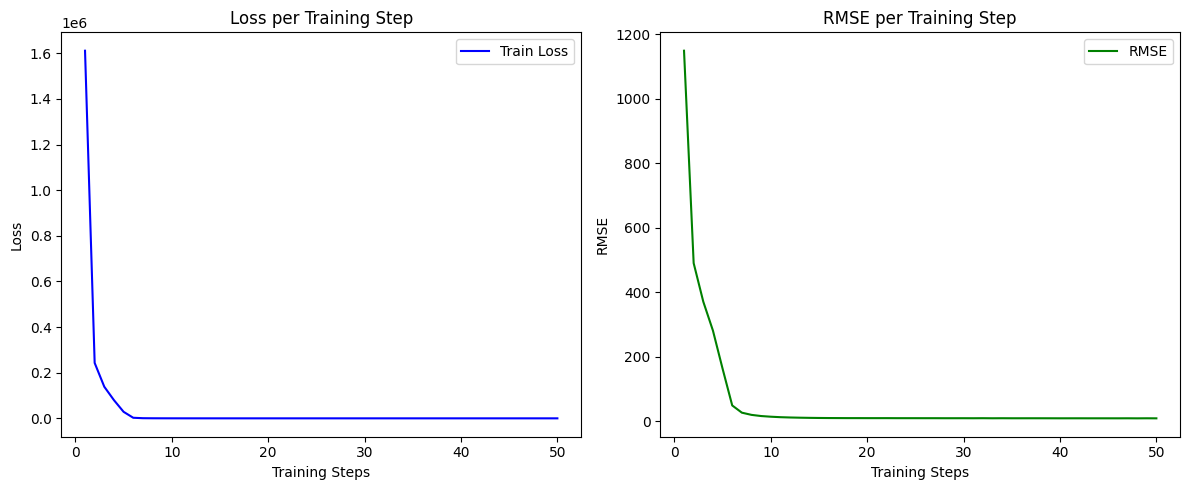

In [ ]:
plot_training_metrics(train_loss, train_rmse)

In [ ]:
predicts, valid_loss, valid_rmse = test(
    model=model,
    criterion=criterion,
    test_loader=test_loader)


Validation Loss: 86.1458, Validation RMSE (original scale): 9.2815


In [39]:
def plot_y_test_vs_y_pred(y_test, y_pred):

    plt.figure(figsize=(10, 6))

    #облако точек для реальных значений
    plt.scatter(np.arange(len(y_test)), y_test, color='blue', alpha=0.6, label='True Values (y_test)')

    #облако точек для предсказанных значений
    plt.scatter(np.arange(len(y_pred)), y_pred, color='orange', alpha=0.6, label='Predicted Values (y_pred)')


    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.title('True vs Predicted Values')

    plt.legend()

    plt.grid(True)

    plt.tight_layout()

    plt.show()


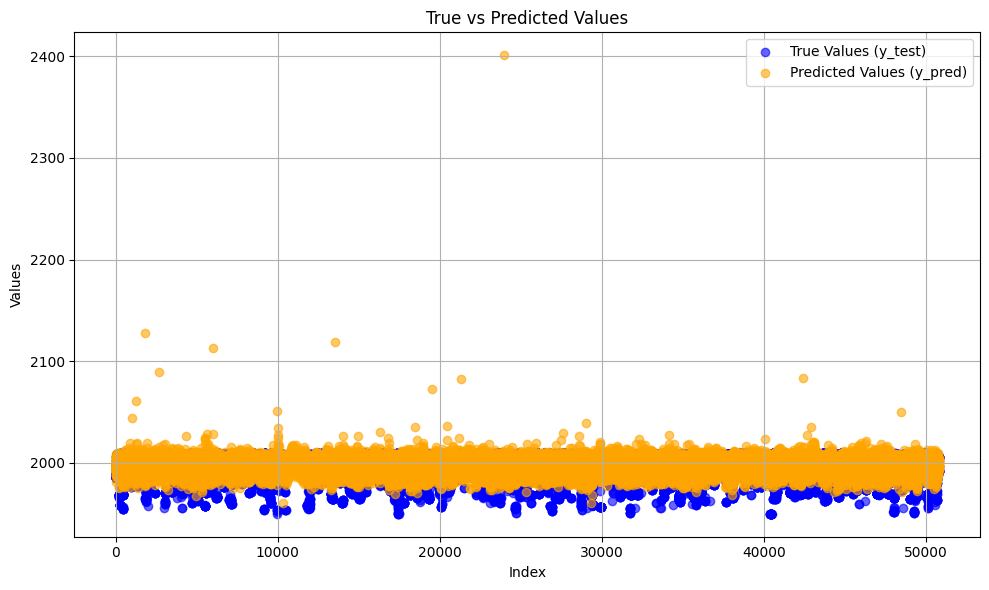

In [ ]:
plot_y_test_vs_y_pred(y_test, predicts)

Ура, вышли песни за 2400 год.

In [ ]:
y_train_tensor = torch.tensor(y_train)
print("Unique labels:", torch.unique(y_train_tensor))
print("Output size of the model:", OUTPUT_SIZE)

Unique labels: tensor([1922, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934,
        1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946,
        1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
        1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
        1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
        1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
        1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
        2007, 2008, 2009, 2010, 2011])
Output size of the model: 1


In [ ]:
assert predicts.shape[0] == y_test.shape[0]

In [33]:
class MyModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=INPUT_SIZE, out_features=HIDDEN_SIZE1)
        self.norm1 = nn.LayerNorm(HIDDEN_SIZE1) #нормализация
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2) #дропаут
        self.layer2 = nn.Linear(in_features=HIDDEN_SIZE1, out_features=HIDDEN_SIZE2)
        self.norm2 = nn.LayerNorm(HIDDEN_SIZE2)
        self.act2 = nn.ReLU()
        #self.dropout2 = nn.Dropout(0.1)
        self.layer3 = nn.Linear(in_features=HIDDEN_SIZE2, out_features=HIDDEN_SIZE3)
        self.norm3 = nn.LayerNorm(HIDDEN_SIZE3)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(in_features=HIDDEN_SIZE2, out_features=OUTPUT_SIZE)




    def forward(self, x):
        x = self.layer1(x)
        x = self.norm1(x)
        x = self.act1(x)
        x = self.dropout1(x)

        x = self.layer2(x)
        x = self.norm2(x)
        x = self.act2(x)
        #x = self.dropout2(x)


        #x = self.layer3(x)
        #x = self.norm3(x)
        #x = self.act3(x)
        x = self.output(x)
        return x

In [ ]:
model2 = MyModel2().to(DEVICE) #lr 0.01

optimizer = optim.Adam(model2.parameters(), lr=LEARNING_RATE)

criterion = nn.MSELoss()

In [ ]:
train_loss_values2, train_rmse2 = train(
    model=model2,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader)

EPOCH 1, train_loss: 3920369.7086, train_rmse: 1979.9572
EPOCH 10, train_loss: 206752.0862, train_rmse: 451.7104
EPOCH 20, train_loss: 69.7995, train_rmse: 8.3491
EPOCH 30, train_loss: 64.7228, train_rmse: 8.0406
EPOCH 40, train_loss: 62.4805, train_rmse: 7.8991
EPOCH 50, train_loss: 61.2374, train_rmse: 7.8200


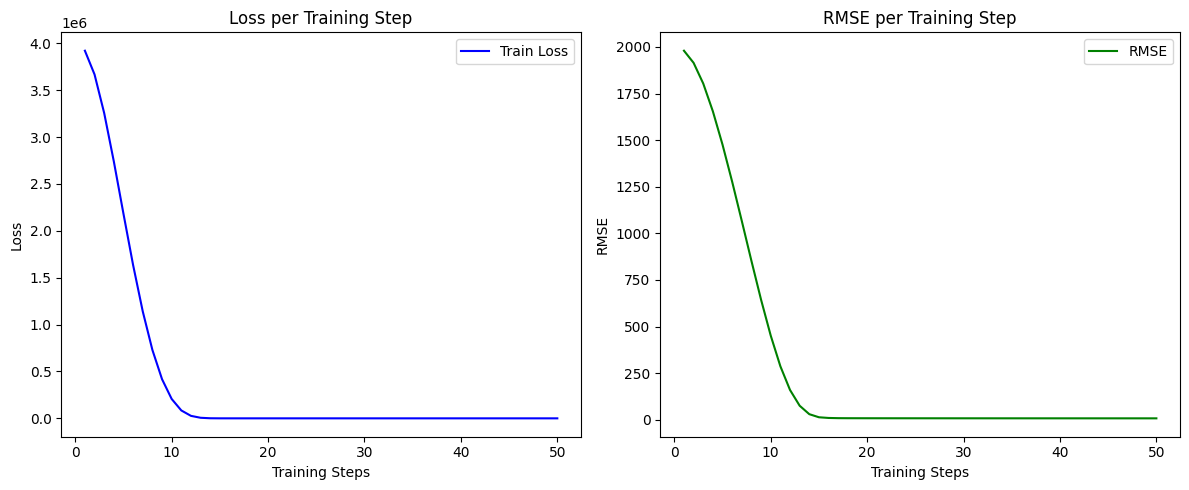

In [ ]:
plot_training_metrics(train_loss_values2, train_rmse2)

In [ ]:
predicts2, valid_loss2, valid_rmse2 = test(
    model=model2,
    criterion=criterion,
    test_loader=test_loader)


Validation Loss: 75.3695, Validation RMSE (original scale): 8.6816


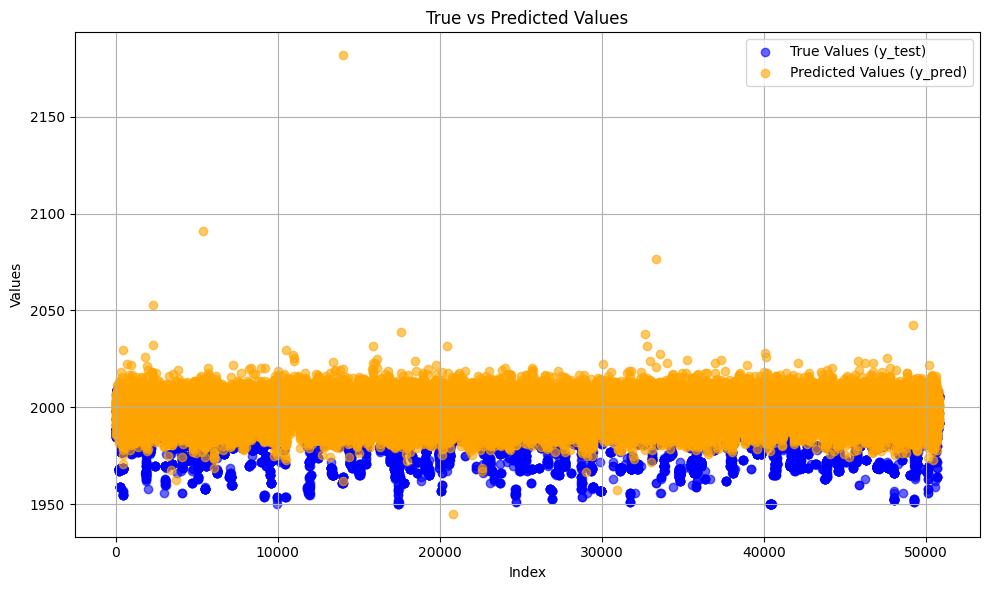

In [ ]:
plot_y_test_vs_y_pred(y_test, predicts2)

In [ ]:
model3 = MyModel2().to(DEVICE) #lr 0.1

optimizer = optim.Adam(model3.parameters(), lr=LEARNING_RATE)


criterion = nn.MSELoss()


In [ ]:
train_loss_values3, train_rmse3 = train(
    model=model3,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader)

EPOCH 1, train_loss: 409658.0498, train_rmse: 269.6098
EPOCH 10, train_loss: 70.4492, train_rmse: 8.3879


KeyboardInterrupt: 

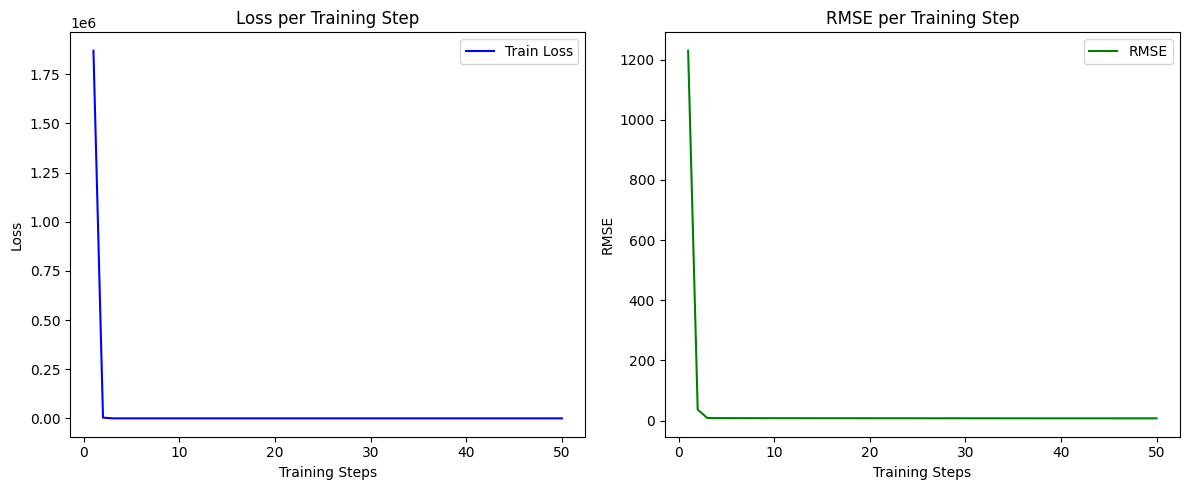

In [ ]:
plot_training_metrics(train_loss_values3, train_rmse3)

In [ ]:
predicts3, valid_loss3, valid_rmse3 = test(
    model=model3,
    criterion=criterion,
    test_loader=test_loader
)


Validation Loss: 79.5742, Validation RMSE (original scale): 8.9204


In [ ]:
model4 = MyModel2().to(DEVICE) #lr 0.05

optimizer = optim.Adam(model4.parameters(), lr=LEARNING_RATE)


criterion = nn.MSELoss()

In [ ]:
train_loss_values4, train_rmse4 = train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader)

EPOCH 1, train_loss: 109176.3434, train_rmse: 78.1319
EPOCH 10, train_loss: 74.6730, train_rmse: 8.6140
EPOCH 20, train_loss: 72.1509, train_rmse: 8.4675
EPOCH 30, train_loss: 70.3760, train_rmse: 8.3636
EPOCH 40, train_loss: 69.7241, train_rmse: 8.3239
EPOCH 50, train_loss: 68.6570, train_rmse: 8.2622


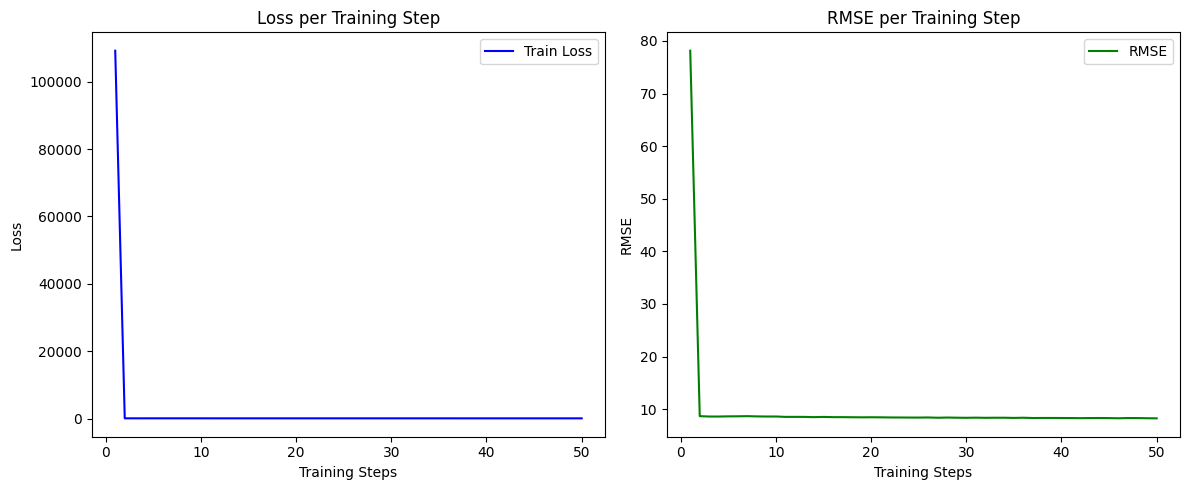

In [ ]:
plot_training_metrics(train_loss_values4, train_rmse4)

In [ ]:
predicts4, valid_loss4, valid_rmse4 = test(
    model=model4,
    criterion=criterion,
    test_loader=test_loader
)


Validation Loss: 77.3028, Validation RMSE (original scale): 8.7922


In [34]:
from torch.optim.lr_scheduler import MultiStepLR
model5 = MyModel2().to(DEVICE) #lr 0.05, 2 layers 128, 64

optimizer = optim.Adam(model5.parameters(), lr=LEARNING_RATE)

criterion = nn.MSELoss()
scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

In [35]:
train_loss_values5, train_rmse5 = train(
    model=model5,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader, scheduler=scheduler)

EPOCH 1, train_loss: 105329.8089, train_rmse: 75.7109
EPOCH 10, train_loss: 74.3169, train_rmse: 8.5943
EPOCH 20, train_loss: 72.2279, train_rmse: 8.4733
EPOCH 30, train_loss: 70.9107, train_rmse: 8.3939
EPOCH 40, train_loss: 64.7526, train_rmse: 8.0250
EPOCH 50, train_loss: 64.5837, train_rmse: 8.0159


In [36]:
predicts5, valid_loss5, valid_rmse5 = test(
    model=model5,
    criterion=criterion,
    test_loader=test_loader)



Validation Loss: 73.3544, Validation RMSE (original scale): 8.5647


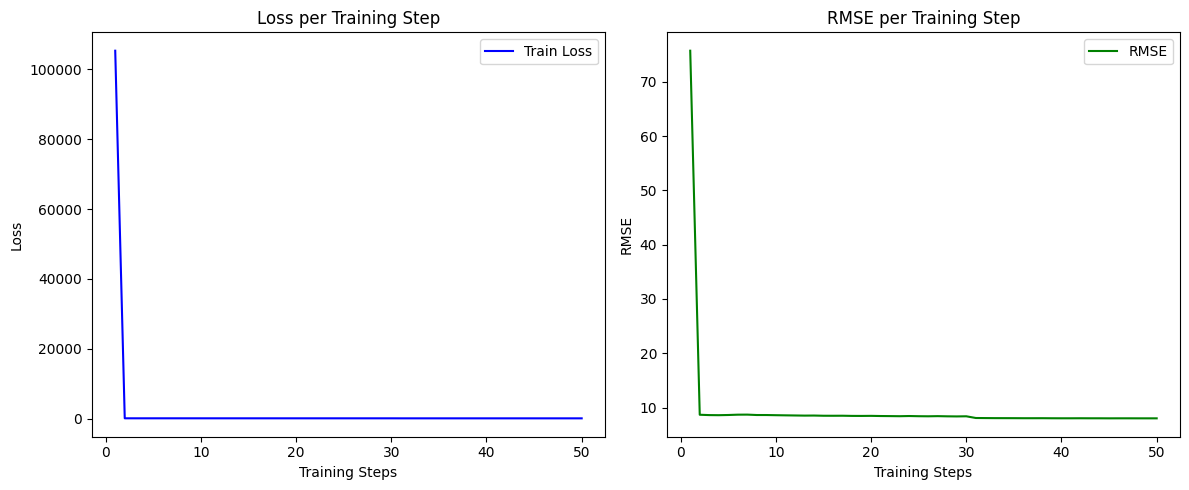

In [41]:
plot_training_metrics(train_loss_values5, train_rmse5)

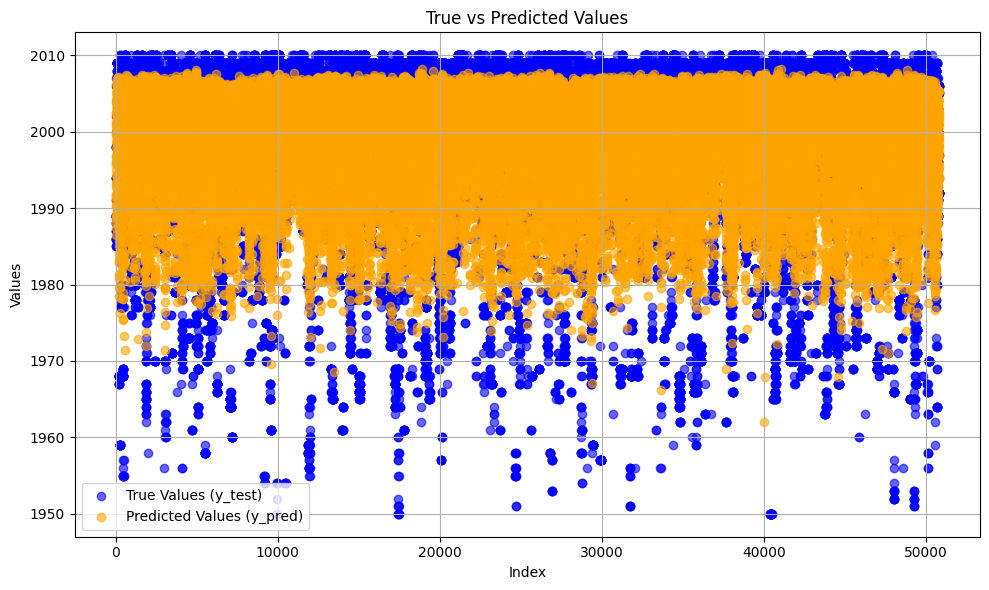

In [44]:
plot_y_test_vs_y_pred(y_test, predicts5)

Предсказанные значения находятся в диапазоне самых типичных значений в тесте.


In [86]:
from torch.optim.lr_scheduler import MultiStepLR
model6 = MyModel2().to(DEVICE)  #2 layers 256, 128


optimizer = optim.Adam(model6.parameters(), lr=LEARNING_RATE)

criterion = nn.MSELoss()
scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

In [87]:
train_loss_values6, train_rmse6 = train(
    model=model6,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader, scheduler=scheduler)

EPOCH 1, train_loss: 76218.1573, train_rmse: 57.8380
EPOCH 10, train_loss: 75.4285, train_rmse: 8.6504
EPOCH 20, train_loss: 70.7513, train_rmse: 8.3820
EPOCH 30, train_loss: 68.7672, train_rmse: 8.2620
EPOCH 40, train_loss: 60.5241, train_rmse: 7.7592
EPOCH 50, train_loss: 59.8890, train_rmse: 7.7200


In [88]:
predicts6, valid_loss6, valid_rmse6 = test(
    model=model6,
    criterion=criterion,
    test_loader=test_loader)



Validation Loss: 75.6299, Validation RMSE (original scale): 8.6965


In [22]:
from torch.optim.lr_scheduler import MultiStepLR
model7 = MyModel2().to(DEVICE)  #3 layers 256, 128, 64


optimizer = optim.Adam(model7.parameters(), lr=LEARNING_RATE)

criterion = nn.MSELoss()
scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

In [23]:
train_loss_values7, train_rmse7 = train(
    model=model7,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader, scheduler=scheduler)

EPOCH 1, train_loss: 103060.4062, train_rmse: 74.2458
EPOCH 10, train_loss: 72.9097, train_rmse: 8.5126
EPOCH 20, train_loss: 69.3605, train_rmse: 8.3016
EPOCH 30, train_loss: 67.0199, train_rmse: 8.1598
EPOCH 40, train_loss: 60.3878, train_rmse: 7.7498
EPOCH 50, train_loss: 59.8020, train_rmse: 7.7131


In [24]:
predicts7, valid_loss7, valid_rmse7 = test(
    model=model7,
    criterion=criterion,
    test_loader=test_loader)



Validation Loss: 75.0520, Validation RMSE (original scale): 8.6633


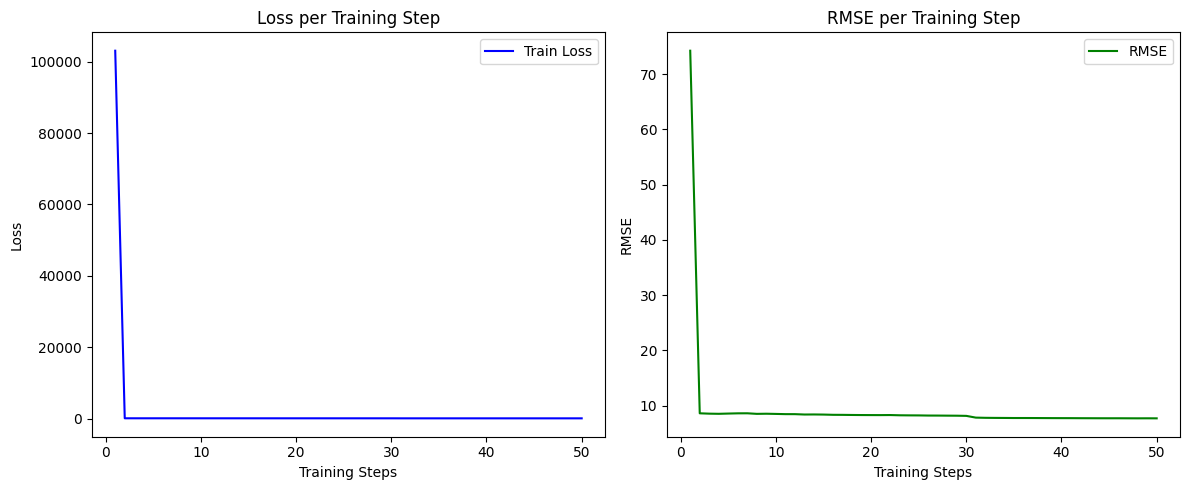

In [42]:
plot_training_metrics(train_loss_values7, train_rmse7)

In [28]:
from torch.optim.lr_scheduler import MultiStepLR
model8 = MyModel2().to(DEVICE)  #3 layers 128, 64, 32


optimizer = optim.Adam(model8.parameters(), lr=LEARNING_RATE)

criterion = nn.MSELoss()
scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

In [29]:
train_loss_values8, train_rmse8 = train(
    model=model8,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader, scheduler=scheduler)

EPOCH 1, train_loss: 144747.4705, train_rmse: 100.8042
EPOCH 10, train_loss: 72.6965, train_rmse: 8.5023
EPOCH 20, train_loss: 70.1297, train_rmse: 8.3509
EPOCH 30, train_loss: 69.0563, train_rmse: 8.2860
EPOCH 40, train_loss: 64.0927, train_rmse: 7.9856
EPOCH 50, train_loss: 63.6760, train_rmse: 7.9590


In [30]:
predicts8, valid_loss8, valid_rmse8 = test(
    model=model8,
    criterion=criterion,
    test_loader=test_loader)



Validation Loss: 74.6362, Validation RMSE (original scale): 8.6392


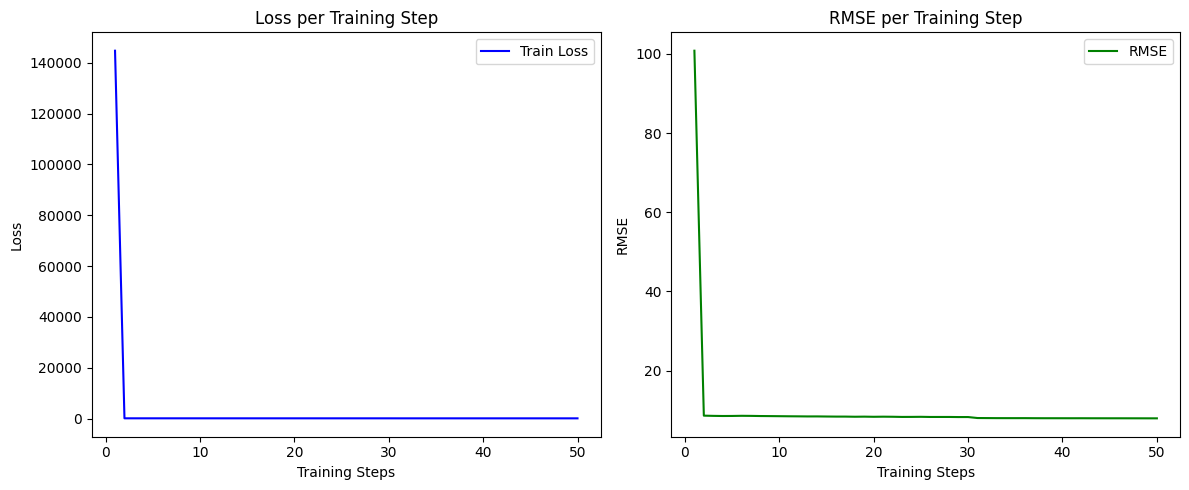

In [43]:
plot_training_metrics(train_loss_values8, train_rmse8)

## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

Первая модель: batch size = 1000, lr = 0.01, 2 layers, hidden size = 128, relu, Adam. Из обработки данных только Standart Scaler для X.  
EPOCH 50, train_loss: 95.0321, train_rmse: 9.6107  
Validation Loss: 88.4998, Validation RMSE (original scale): 9.4074  
Начнем с обработки данных. В предсказаниях оказались очень большие значения. Посмотрела на графике, в каком диапазоне находится большая часть значений y и удалила выбросы. У Ridge RMSE снизилось на 0.3.
MLP: Validation Loss: 83.8588, Validation RMSE (original scale): 9.1574
Я пробовала добавить нормализацию y  через среднее и стандартное отклонение, а потом возвращать предсказания и rmse к изначальному масштабу внутри функций для обучения, но из-за этого стало не хватать ОЗУ и на этапе предсказания среда выполнения отключалась.  
Попробовала снизить размерность через PCA. По графику кол-во компонент должно быть в районе 5-7, попробовала 7, но у Ridge RMSE выросло до 10. У MLP тоже стало хуже: Validation Loss: 127.6729, Validation RMSE (original scale): 11.2992  
Попробовала еще задавать не кол-во главных компонент, а процент сохраняемой дисперсии, но на 0.95 результат у Ridge все так же был хуже, чем без PCA, поэтому в итоге убрала его вообще.  
Параметры модели:  
Попробовала подобрать hidden size. Расставила разные размеры слоев (128 и 64)  
EPOCH 50, train_loss: 80.0619, train_rmse: 8.9407
Validation Loss: 86.1458, Validation RMSE (original scale): 9.2815, похоже на переобучение, попробовала добавить dropout.  
20% после обеих ф. активации: EPOCH 30, train_loss: 37284.0453, train_rmse: 193.0383, даже доучивать не стала  
10%: EPOCH 50, train_loss: 15724.5544, train_rmse: 125.3645  
Dropout только после первого слоя: EPOCH 50, train_loss: 1379.0888, train_rmse: 37.1262  
убрала дропауты  
BatchNorm после каждого слоя:  
Validation Loss: 90.0494, Validation RMSE (original scale): 9.4894  
LayerNorm (в семинаре было написано, что BatchNorm обычно используют для картинок, и я поискала нормализацию для текста):  Validation Loss: 75.3695, Validation RMSE (original scale): 8.6816  
НО EPOCH 50, train_loss: 61.2374, train_rmse: 7.8200, похоже на переобучение  
Все это время была lr 0.001, Scheduler'ы будут ее занижать, поэтому перед тем, как пробовать их, решила попробовать установить lr 0.1 (пока оставила LayerNorm)  
EPOCH 50, train_loss: 60.0327, train_rmse: 7.7426  
Validation Loss: 79.5742, Validation RMSE (original scale): 8.9204  
Еще раз попробовала добать dropout 0.1 после первого слоя:  
Validation Loss: 74.3709, Validation RMSE (original scale): 8.6239  
EPOCH 50, train_loss: 63.0874, train_rmse: 7.9376  
Все еще переобучение.  Наугад попробовала lr 0.05. На трейне RMSE выросла, зато на тесте снизилась.  
EPOCH 50, train_loss: 66.2442, train_rmse: 8.1319  
Validation Loss: 73.3951, Validation RMSE (original scale): 8.5671   
Dropout до 0.2 (все еще только первого слоя):  
Validation Loss: 84.2829, Validation RMSE (original scale): 9.1806  
EPOCH 50, train_loss: 68.9698, train_rmse: 8.2796   
Попробовала уменьшить размер батча до 256:  
Validation Loss: 73.0167, Validation RMSE (original scale): 8.5450  
батч 100:  
Validation Loss: 77.3028, Validation RMSE (original scale): 8.7922  
Вернула 256.  
Попробовала уменьшать lr.  
MultistepLR:  
EPOCH 50, train_loss: 64.5837, train_rmse: 8.0159  
Validation Loss: 73.3544, Validation RMSE (original scale): 8.5647  
Кол-во нейронов в скрытых слоях:  
256, 128:  
EPOCH 50, train_loss: 59.8890, train_rmse: 7.7200  
Validation Loss: 75.6299, Validation RMSE (original scale): 8.6965  
3 слоя:  
256, 128, 64:  
EPOCH 50, train_loss: 59.8020, train_rmse: 7.7131  
Validation Loss: 75.0520, Validation RMSE (original scale): 8.6633  
128, 64, 32:  
EPOCH 50, train_loss: 63.6760, train_rmse: 7.9590  
Validation Loss: 74.6362, Validation RMSE (original scale): 8.6392

Лучший результат оказался у модели 5:  
Validation Loss: 73.3544, Validation RMSE (original scale): 8.5647  
Архитектура: размер батча 256, lr 0.05 + MultistepLR, 50 эпох, линейный слой 128 н., ReLu, LayerNorm, Dropout 0.2, линейный слой 64 н., ReLu, LayerNorm, выходной слой 1 н.  
Optimizer Adam.


